# CartoonGAN (Expt2 - with added dropout in Generator)

## Install & Import dependencies

apt-get update && apt-get install ffmpeg libsm6 libxext6 -y

In [1]:
!pip install -q numpy matplotlib tensorboard opencv-python scikit-image gradio

In [1]:
import os
import cv2
import math
import time
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from torch import sigmoid
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image, ImageFilter
from skimage.filters import gaussian
from skimage import io, img_as_ubyte
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split


## Generate dataset

### cartoons images

- extract images and place in folder `cartoons` by executing cell below

##### data-loader

In [2]:
image_size = 256
batch_size = 32

In [3]:
if not os.path.exists(os.path.join(os.getcwd(), 'data', 'train', 'cartoons')):
    os.makedirs(os.path.join(os.getcwd(), 'data', 'train', 'cartoons'))

In [4]:
if not os.path.exists(os.path.join(os.getcwd(), 'data', 'train', 'cartoons_smoothed')):
    os.makedirs(os.path.join(os.getcwd(), 'data', 'train', 'cartoons_smoothed'))

In [5]:
transformer = T.Compose([
    T.CenterCrop(image_size),  # Resize the image to 256x256
    T.ToTensor()  # Convert the image to a PyTorch tensor
])

cartoon_dataset = ImageFolder('data/train/cartoons/', transformer)
len_training_set = math.floor(len(cartoon_dataset) * 0.9)
len_valid_set = len(cartoon_dataset) - len_training_set

training_set, _ = random_split(cartoon_dataset, (len_training_set, len_valid_set))
cartoon_image_dataloader_train = DataLoader(training_set, batch_size, shuffle=True, num_workers=0)

#### show examples

torch.Size([3, 256, 256])
Current range: 0.0 to 1.0


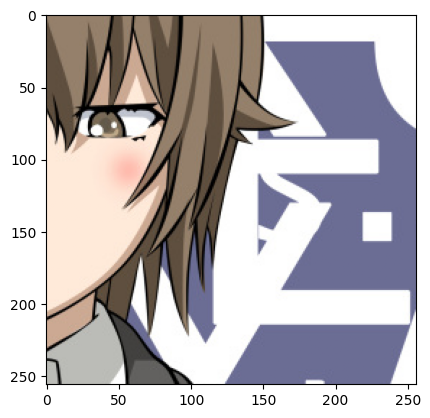

In [6]:
def show_sample_image(dataloader):
  iterator = iter(dataloader)
  sample_batch, _ = next(iterator)
  first_sample_image_of_batch = sample_batch[0]
  print(first_sample_image_of_batch.size())
  print("Current range: {} to {}".format(first_sample_image_of_batch.min(), first_sample_image_of_batch.max()))
  plt.imshow(np.transpose(first_sample_image_of_batch.numpy(), (1, 2, 0)))

show_sample_image(cartoon_image_dataloader_train)

### edge-smoothed cartoons images

- extract images and place in folder `cartoons_smoothed` by executing cell below

##### data-loader

same configuration as cartoon data loader above

In [7]:
smoothed_cartoon_dataset = ImageFolder('data/train/cartoons_smoothed/', transformer)
len_training_set = math.floor(len(smoothed_cartoon_dataset) * 0.9)
len_valid_set = len(smoothed_cartoon_dataset) - len_training_set
training_set, _ = random_split(smoothed_cartoon_dataset, (len_training_set, len_valid_set))
smoothed_cartoon_image_dataloader_train = DataLoader(training_set, batch_size, shuffle=True, num_workers=0)

#### show examples

torch.Size([3, 256, 256])
Current range: 0.01568627543747425 to 1.0


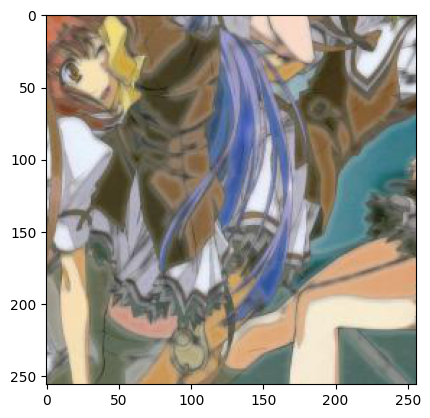

In [8]:
show_sample_image(smoothed_cartoon_image_dataloader_train)

### photos

- extract images and place in folder `real` by executing cell below

##### data-loader
same configuration as cartoon data loader above

In [9]:
photo_dataset = ImageFolder('data/train/real/', transformer)
len_training_set = math.floor(len(photo_dataset) * 0.9)
len_valid_set = len(photo_dataset) - len_training_set
training_set, validation_set = random_split(photo_dataset, (len_training_set, len_valid_set))
photo_dataloader_train = DataLoader(training_set, batch_size, shuffle=True, num_workers=0)
photo_dataloader_valid = DataLoader(validation_set, batch_size, shuffle=True, num_workers=0)

#### show examples

torch.Size([3, 256, 256])
Current range: 0.0 to 1.0


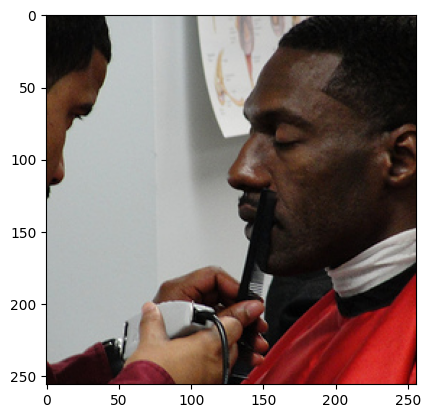

In [10]:
show_sample_image(photo_dataloader_train)

## Setup tensorboard

Use tensorboard to have an eye on weights and losses.

In [11]:
tensorboard_logdir = 'tensorboard'
writer = SummaryWriter(tensorboard_logdir)

### Generator

In [2]:
class ResidualBlock(nn.Module):
  def __init__(self):
    super(ResidualBlock, self).__init__()
    self.conv_1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
    self.conv_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
    self.norm_1 = nn.BatchNorm2d(256)
    self.norm_2 = nn.BatchNorm2d(256)

  def forward(self, x):
    output = self.norm_2(self.conv_2(F.relu(self.norm_1(self.conv_1(x)))))
    return output + x 

class Generator(nn.Module):
    def __init__(self):
      super(Generator, self).__init__()
      self.conv_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=1, padding=3)
      self.norm_1 = nn.BatchNorm2d(64)
      
      # down-convolution #
      self.conv_2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
      self.conv_3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
      self.norm_2 = nn.BatchNorm2d(128)
      
      self.conv_4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1)
      self.conv_5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
      self.norm_3 = nn.BatchNorm2d(256)
      self.dropout = nn.Dropout(0.2)
      
      # residual blocks #
      residualBlocks = []
      for l in range(8):
        residualBlocks.append(ResidualBlock())
      self.res = nn.Sequential(*residualBlocks)
      
      # up-convolution #
      self.conv_6 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
      self.conv_7 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
      self.norm_4 = nn.BatchNorm2d(128)

      self.conv_8 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
      self.conv_9 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
      self.norm_5 = nn.BatchNorm2d(64)
      
      self.conv_10 = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=7, stride=1, padding=3)

    def forward(self, x):
      x = F.relu(self.norm_1(self.conv_1(x)))
      x = self.dropout(x)
      x = F.relu(self.norm_2(self.conv_3(self.conv_2(x))))
      x = F.relu(self.norm_3(self.conv_5(self.conv_4(x))))
      
      x = self.res(x)
      x = F.relu(self.norm_4(self.conv_7(self.conv_6(x))))
      x = F.relu(self.norm_5(self.conv_9(self.conv_8(x))))
      x = self.dropout(x)

      x = self.conv_10(x)

      x = sigmoid(x)

      return x

In [3]:
G = Generator()
print(G)

Generator(
  (conv_1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (res): Sequential(
    (0): ResidualBlock(
      (conv_1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm_1): BatchNorm2d(256, eps=1e-05, momentum=0.1, a

### Discriminator

In [4]:
class Discriminator(nn.Module):
  def __init__(self):
     super(Discriminator, self).__init__()
     self.conv_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
      
     self.conv_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
     self.conv_3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
     self.norm_1 = nn.BatchNorm2d(128)
      
     self.conv_4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1)
     self.conv_5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
     self.norm_2 = nn.BatchNorm2d(256)
    
     self.conv_6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
     self.norm_3 = nn.BatchNorm2d(256)
    
     self.conv_7 = nn.Conv2d(in_channels=256, out_channels=1, kernel_size=3, stride=1, padding=1)

  def forward(self, x):
    x = F.leaky_relu(self.conv_1(x))
    x = F.leaky_relu(self.norm_1(self.conv_3(F.leaky_relu(self.conv_2(x)))), negative_slope=0.2)
    x = F.leaky_relu(self.norm_2(self.conv_5(F.leaky_relu(self.conv_4(x)))), negative_slope=0.2)
    x = F.leaky_relu(self.norm_3(self.conv_6(x)), negative_slope=0.2)
    x = self.conv_7(x)
    x = sigmoid(x)
    
    return x

In [5]:
D = Discriminator()
print(D)

Discriminator(
  (conv_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_7): Conv2d(256, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


### use device CPU or GPU

In [6]:
device = torch.device('cpu')

if torch.cuda.is_available():
  device = torch.device('cuda')
  print("Train on GPU.")
else:
  print("No cuda available")

G.to(device)
D.to(device)

device

Train on GPU.


device(type='cuda')

### VGG-16
Load already downloaded vgg-16 weights from drive, or download and save to drive.

In [7]:
path_to_pretrained_vgg16 = "vgg16_weights.pth"

vgg16 = models.vgg16(pretrained=True)
torch.save(vgg16, path_to_pretrained_vgg16)
vgg16 = vgg16.to(device) 
print(vgg16)


feature_extractor = vgg16.features[:24]
for param in feature_extractor.parameters():
  param.require_grad = False

print(feature_extractor)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Two loss functions

- discriminator loss
- generator initialization phase loss and generator loss

In [8]:
from torchvision import models
from torch.nn import BCELoss

class DiscriminatorLoss(torch.nn.Module):
  def __init__(self):
      super(DiscriminatorLoss, self).__init__()
      self.bce_loss = BCELoss()

  def forward(self, discriminator_output_of_cartoon_input,
              discriminator_output_of_cartoon_smoothed_input,
              discriminator_output_of_generated_image_input,
              epoch,
              write_to_tensorboard=False):

    return self._adversarial_loss(discriminator_output_of_cartoon_input,
                     discriminator_output_of_cartoon_smoothed_input,
                     discriminator_output_of_generated_image_input,
                     epoch,
                     write_to_tensorboard)

  def _adversarial_loss(self, discriminator_output_of_cartoon_input,
                     discriminator_output_of_cartoon_smoothed_input,
                     discriminator_output_of_generated_image_input,
                     epoch,
                     write_to_tensorboard):

   
    actual_batch_size = discriminator_output_of_cartoon_input.size()[0]
    zeros = torch.zeros([actual_batch_size, 1, 64, 64]).to(device)
    ones = torch.ones([actual_batch_size, 1, 64, 64]).to(device)

    d_loss_cartoon = self.bce_loss(discriminator_output_of_cartoon_input, ones)
    d_loss_cartoon_smoothed = self.bce_loss(discriminator_output_of_cartoon_smoothed_input, zeros)
    d_loss_generated_input = self.bce_loss(discriminator_output_of_generated_image_input, zeros)

    d_loss = d_loss_cartoon + d_loss_cartoon_smoothed + d_loss_generated_input

    if write_to_tensorboard:
      writer.add_scalar('d_loss_cartoon', d_loss_cartoon,epoch)
      writer.add_scalar('d_loss_cartoon_smoothed', d_loss_cartoon_smoothed, epoch)
      writer.add_scalar('d_loss_generated_input', d_loss_generated_input, epoch)
      writer.add_scalar('d_loss', d_loss, epoch)

    return d_loss

In [9]:
class GeneratorLoss(torch.nn.Module):
  def __init__(self):
      super(GeneratorLoss, self).__init__()
      self.w = 0.000005
      self.bce_loss = BCELoss()
      self.feature_extractor = vgg16.features[:24]
      for param in self.feature_extractor.parameters():
        param.require_grad = False

  def forward(self, discriminator_output_of_generated_image_input,
              generator_input,
              generator_output,
              epoch,
              is_init_phase=False,
              write_to_tensorboard=False):
    if is_init_phase:
      g_content_loss = self._content_loss(generator_input, generator_output)
      g_adversarial_loss = 0.0
      g_loss = g_content_loss
    else:
      g_adversarial_loss = self._adversarial_loss_generator_part_only(discriminator_output_of_generated_image_input)
      g_content_loss = self._content_loss(generator_input, generator_output)
      g_loss = g_adversarial_loss + self.w * g_content_loss

    if write_to_tensorboard:
      writer.add_scalar('g_adversarial_loss', g_adversarial_loss, epoch)
      writer.add_scalar('g_content_loss', g_content_loss, epoch)
      writer.add_scalar('g_loss', g_loss, epoch)

    return g_loss

  def _adversarial_loss_generator_part_only(self, discriminator_output_of_generated_image_input):
    actual_batch_size = discriminator_output_of_generated_image_input.size()[0]
    ones = torch.ones([actual_batch_size, 1, 64, 64]).to(device)
    return self.bce_loss(discriminator_output_of_generated_image_input, ones)

  def _content_loss(self, generator_input, generator_output):
    return (self.feature_extractor(generator_output) - self.feature_extractor(generator_input)).norm(p=1)

In [10]:
discriminatorLoss = DiscriminatorLoss()
generatorLoss = GeneratorLoss()

## Optimizer

In [11]:

lr = 0.0002
beta1 = 0.5
beta2 = 0.999

d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

## Saving
To make training resumeable, I save some checkpoints to google drive and load them, if existing, before run the training.

I also save weights and bias from generator and discriminator to tensorboard.

For checking some intermediate images of the generator, I save them to google drive.

In [12]:
intermediate_results_training_path = "intermediate_results/training/"
!mkdir -p intermediate_results/training/

In [13]:
def save_training_result(input, output):
  # input/output has batch-size number of images, get first one and detach from tensor
  image_input = input[0].detach().cpu().numpy()
  image_output = output[0].detach().cpu().numpy()
  # transponse image from torch.Size([3, 256, 256]) to (256, 256, 3)
  image_input = np.transpose(image_input, (1, 2, 0))
  image_output = np.transpose(image_output, (1, 2, 0))

  # generate filenames as timestamp, this orders the output by time
  filename = str(int(time.time()))
  path_input = intermediate_results_training_path + filename + "_input.jpg"
  path_output = intermediate_results_training_path + filename + ".jpg"
  plt.imsave(path_input, image_input)
  plt.imsave(path_output, image_output)

In [14]:
def write_model_weights_and_bias_to_tensorboard(prefix, state_dict, epoch):
  for param in state_dict:
      writer.add_histogram(f"{prefix}_{param}", state_dict[param], epoch)

## Training

In [15]:
def train(_num_epochs, checkpoint_dir, best_valid_loss, epochs_already_done, losses, validation_losses):
  init_epochs = 10
  print_every = 100
  start_time = time.time()

  for epoch in range(_num_epochs - epochs_already_done):
    epoch = epoch + epochs_already_done

    for index, ((photo_images, _), (smoothed_cartoon_images, _), (cartoon_images, _)) in enumerate(zip(photo_dataloader_train, smoothed_cartoon_image_dataloader_train, cartoon_image_dataloader_train)):
      batch_size = photo_images.size(0)
      photo_images = photo_images.to(device)
      smoothed_cartoon_images = smoothed_cartoon_images.to(device)
      cartoon_images = cartoon_images.to(device)

      # training the discriminator
      d_optimizer.zero_grad()
      
      d_of_cartoon_input = D(cartoon_images)
      d_of_cartoon_smoothed_input = D(smoothed_cartoon_images)
      d_of_generated_image_input = D(G(photo_images))

      write_only_one_loss_from_epoch_not_every_batch_loss = (index == 0)

      d_loss = discriminatorLoss(d_of_cartoon_input,
                                 d_of_cartoon_smoothed_input,
                                 d_of_generated_image_input,
                                 epoch,
                                 write_to_tensorboard=write_only_one_loss_from_epoch_not_every_batch_loss)

      d_loss.backward()
      d_optimizer.step()

      # training the generator
      g_optimizer.zero_grad()

      g_output = G(photo_images)

      d_of_generated_image_input = D(g_output)

      if epoch < init_epochs:
        # init
        init_phase = True
      else:
        # training
        init_phase = False

      g_loss = generatorLoss(d_of_generated_image_input,
                              photo_images,
                              g_output,
                              epoch,
                              is_init_phase=init_phase,
                              write_to_tensorboard=write_only_one_loss_from_epoch_not_every_batch_loss)

      g_loss.backward()
      g_optimizer.step()

      if (index % print_every) == 0:
        losses.append((d_loss.item(), g_loss.item()))
        now = time.time()
        current_run_time = now - start_time
        start_time = now
        print("Epoch {}/{} | d_loss {:6.4f} | g_loss {:6.4f} | time {:2.0f}s | total no. of losses {}".format(epoch+1, _num_epochs, d_loss.item(), g_loss.item(), current_run_time, len(losses)))
    
    # writing to tensorboard
      #write_model_weights_and_bias_to_tensorboard('D', D.state_dict(), epoch)
      #write_model_weights_and_bias_to_tensorboard('G', G.state_dict(), epoch)
    # saving some intermediate results during training
    save_training_result(photo_images, g_output)

    # validating
    with torch.no_grad():
      D.eval()
      G.eval()

      for batch_index, (photo_images, _) in enumerate(photo_dataloader_valid):
        photo_images = photo_images.to(device)

        g_output = G(photo_images)
        d_of_generated_image_input = D(g_output)
        g_valid_loss = generatorLoss(d_of_generated_image_input,
                                      photo_images,
                                      g_output,
                                      epoch,
                                      is_init_phase=init_phase,
                                      write_to_tensorboard=write_only_one_loss_from_epoch_not_every_batch_loss)

        if batch_index % print_every == 0:
          validation_losses.append(g_valid_loss.item())
          now = time.time()
          current_run_time = now - start_time
          start_time = now
          print("Epoch {}/{} | validation loss {:6.4f} | time {:2.0f}s | total no. of losses {}".format(epoch+1, _num_epochs, g_valid_loss.item(), current_run_time, len(validation_losses)))

    D.train()
    G.train()
    
    if(g_valid_loss.item() < best_valid_loss):
      print("Generator loss improved from {} to {}".format(best_valid_loss, g_valid_loss.item()))
      best_valid_loss = g_valid_loss.item()
  
    # saving checkpoint
    checkpoint = {'g_valid_loss': g_valid_loss.item(),
                  'best_valid_loss': best_valid_loss,
                  'losses': losses,
                  'validation_losses': validation_losses,
                  'last_epoch': epoch+1,
                  'd_state_dict': D.state_dict(),
                  'g_state_dict': G.state_dict(),
                  'd_optimizer_state_dict': d_optimizer.state_dict(),
                  'g_optimizer_state_dict': g_optimizer.state_dict()
                }
    print("Save checkpoint for validation loss of {}".format(g_valid_loss.item()))
    torch.save(checkpoint, checkpoint_dir + '/checkpoint_epoch_{:03d}.pth'.format(epoch+1))
    if(best_valid_loss == g_valid_loss.item()):
      print("Overwrite best checkpoint")
      torch.save(checkpoint, checkpoint_dir + '/best_checkpoint.pth')
    
  return losses, validation_losses

In [21]:
from os import listdir

checkpoint_dir = 'checkpoints'
checkpoints = listdir(checkpoint_dir)
num_epochs = 210 + 10 # training + init phase
epochs_already_done = 0
best_valid_loss = math.inf
losses = []
validation_losses = []

if(len(checkpoints) > 0):
  last_checkpoint = sorted(checkpoints)[-1]
  checkpoint = torch.load(checkpoint_dir + '/' + last_checkpoint, map_location=torch.device(device))
  best_valid_loss = checkpoint['best_valid_loss']
  epochs_already_done = checkpoint['last_epoch']
  losses = checkpoint['losses']
  validation_losses = checkpoint['validation_losses']

  D.load_state_dict(checkpoint['d_state_dict'])
  G.load_state_dict(checkpoint['g_state_dict'])
  d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
  g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
  print('Load checkpoint {} with g_valid_loss {}, best_valid_loss {}, {} epochs and total no of losses {}'.format(last_checkpoint, checkpoint['g_valid_loss'], best_valid_loss, epochs_already_done, len(losses)))


KeyError: 'best_valid_loss'

In [29]:
losses, validation_losses = train(num_epochs, checkpoint_dir, best_valid_loss, epochs_already_done, losses, validation_losses)

Epoch 1/220 | d_loss 2.0650 | g_loss 2709910.5000 | time  4s | total no. of losses 1
Epoch 1/220 | d_loss 0.4418 | g_loss 2469902.5000 | time 141s | total no. of losses 2
Epoch 1/220 | validation loss 2696117.0000 | time 17s | total no. of losses 1
Generator loss improved from inf to 1350057.875
Save checkpoint for validation loss of 1350057.875
Overwrite best checkpoint
Epoch 2/220 | d_loss 0.3503 | g_loss 2486197.2500 | time  6s | total no. of losses 3
Epoch 2/220 | d_loss 0.1499 | g_loss 2528307.5000 | time 140s | total no. of losses 4
Epoch 2/220 | validation loss 2535169.7500 | time 17s | total no. of losses 2
Generator loss improved from 1350057.875 to 1239591.0
Save checkpoint for validation loss of 1239591.0
Overwrite best checkpoint
Epoch 3/220 | d_loss 0.2460 | g_loss 2784573.5000 | time  6s | total no. of losses 5
Epoch 3/220 | d_loss 0.0920 | g_loss 2533373.0000 | time 141s | total no. of losses 6
Epoch 3/220 | validation loss 2556306.7500 | time 17s | total no. of losses 3

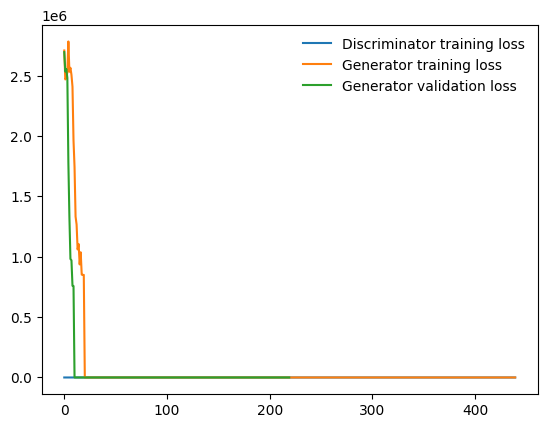

In [30]:
%matplotlib inline
%config InlineBackend.figure.format = 'retina'


d_losses = [x[0] for x in losses]
g_losses = [x[1] for x in losses]
plt.plot(d_losses, label='Discriminator training loss')
plt.plot(g_losses, label='Generator training loss')
plt.plot(validation_losses, label='Generator validation loss')
plt.legend(frameon=False)

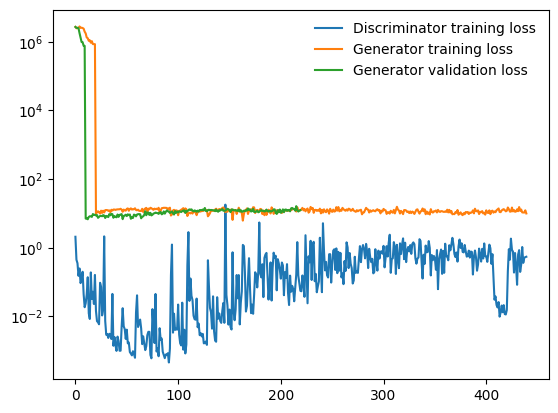

In [50]:
%matplotlib inline
%config InlineBackend.figure.format = 'retina'


d_losses = [x[0] for x in losses]
g_losses = [x[1] for x in losses]
plt.plot(d_losses, label='Discriminator training loss')
plt.plot(g_losses, label='Generator training loss')
plt.plot(validation_losses, label='Generator validation loss')
plt.yscale('log')
plt.legend(frameon=False)

### Show results in tensorboard

In [28]:
%load_ext tensorboard
%tensorboard --logdir='tensorboard'

##Test
Bug: It seems that I make a mistake somewhere in the saving logic of the best checkpoint. The best checkpoint seems not to be the best comic-stlye looking result if compared with the model trained after 210 epochs. Therefore see both results tested below.

In [17]:
checkpoint = torch.load('checkpoints/best_checkpoint.pth', map_location=torch.device(device))
G_inference = Generator()
G_inference.load_state_dict(checkpoint['g_state_dict'])

<All keys matched successfully>

tensor([[[0.5991, 0.6958, 0.7074,  ..., 0.6658, 0.6367, 0.5778],
         [0.6813, 0.6876, 0.7382,  ..., 0.6285, 0.6484, 0.6340],
         [0.6893, 0.7187, 0.6985,  ..., 0.6366, 0.6417, 0.7021],
         ...,
         [0.5366, 0.5515, 0.5504,  ..., 0.5062, 0.5061, 0.5347],
         [0.5491, 0.4274, 0.4916,  ..., 0.5743, 0.5490, 0.5236],
         [0.4753, 0.4524, 0.4509,  ..., 0.5900, 0.5525, 0.5136]],

        [[0.5896, 0.6736, 0.7206,  ..., 0.7282, 0.6882, 0.5998],
         [0.6389, 0.6475, 0.6841,  ..., 0.6833, 0.7106, 0.6641],
         [0.6810, 0.6919, 0.7020,  ..., 0.7002, 0.7162, 0.6985],
         ...,
         [0.5189, 0.5636, 0.5897,  ..., 0.4652, 0.4381, 0.4355],
         [0.4744, 0.4207, 0.4657,  ..., 0.4672, 0.4483, 0.4205],
         [0.4246, 0.4117, 0.4548,  ..., 0.4698, 0.4529, 0.4303]],

        [[0.6291, 0.7378, 0.7708,  ..., 0.7668, 0.7196, 0.6115],
         [0.6697, 0.7474, 0.7732,  ..., 0.7618, 0.8020, 0.7020],
         [0.6787, 0.7338, 0.7556,  ..., 0.7945, 0.8313, 0.

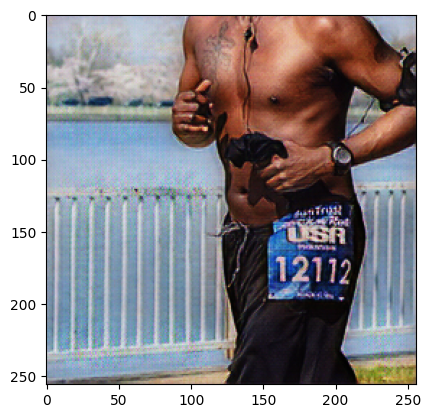

In [32]:
test_images = next(iter(photo_dataloader_valid))[0]
result_images_best_checkpoint = G_inference(test_images)
result_images_checkpoint_after_210_epochs = G(test_images.to(device))
print(result_images_best_checkpoint[0])
plt.imshow(np.transpose(result_images_best_checkpoint[0].detach().numpy(), (1, 2, 0)))

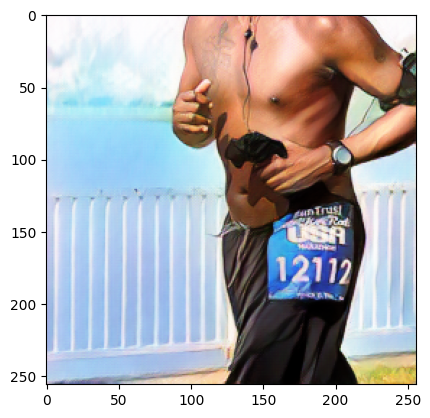

In [33]:
plt.imshow(np.transpose(result_images_checkpoint_after_210_epochs[0].cpu().detach().numpy(), (1, 2, 0)))

### Save weights for production release
In order to have a small file size for a production release, save only the weights of the generator to get a smaller artifact.

This should be the weights of the best checkpoint, but due to the bug described above, I take the latest version of the generator.

Filesize comparison:

Full checkpoint with Generator, Discriminator, Optimizer: 140MB

Generator only: 43MB

In [34]:
generator_release = {'last_epoch': 210,
                    'g_state_dict': G.state_dict(),
                   }
print("Save generator release")
torch.save(generator_release, checkpoint_dir + '/generator_release.pth')

Save generator release


### Test Inference

In [45]:
ep = 179

checkpoint = torch.load(f'checkpoints/checkpoint_epoch_{ep}.pth', map_location=torch.device(device))

best_valid_loss = checkpoint['best_valid_loss']
epochs_already_done = checkpoint['last_epoch']
losses = checkpoint['losses']
validation_losses = checkpoint['validation_losses']

D.load_state_dict(checkpoint['d_state_dict'])
G.load_state_dict(checkpoint['g_state_dict'])
d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
G_inference.load_state_dict(checkpoint['g_state_dict'])
print('Load checkpoint Epoch: {} with g_valid_loss {}, best_valid_loss {}, {} epochs and total no of losses {}'.format(ep, checkpoint['g_valid_loss'], best_valid_loss, epochs_already_done, len(losses)))


Load checkpoint Epoch: 179 with g_valid_loss 6.936197280883789, best_valid_loss 4.2690863609313965, 179 epochs and total no of losses 358


tensor([[[0.9635, 0.9832, 0.9826,  ..., 0.9661, 0.9269, 0.8999],
         [0.9767, 0.9742, 0.9821,  ..., 0.9803, 0.9635, 0.9505],
         [0.9781, 0.9818, 0.9729,  ..., 0.9719, 0.9738, 0.9722],
         ...,
         [0.8959, 0.9445, 0.9534,  ..., 0.2221, 0.1971, 0.2155],
         [0.9159, 0.9437, 0.9589,  ..., 0.2470, 0.2208, 0.2407],
         [0.9000, 0.9374, 0.9673,  ..., 0.2850, 0.3123, 0.3425]],

        [[0.9105, 0.9218, 0.9008,  ..., 0.9005, 0.8195, 0.7695],
         [0.9105, 0.8978, 0.8886,  ..., 0.9046, 0.8499, 0.8528],
         [0.9073, 0.9136, 0.8802,  ..., 0.8895, 0.9006, 0.9074],
         ...,
         [0.4876, 0.5979, 0.5486,  ..., 0.1671, 0.1622, 0.1818],
         [0.5717, 0.5303, 0.5451,  ..., 0.1967, 0.1729, 0.1986],
         [0.5902, 0.5848, 0.6169,  ..., 0.2125, 0.2395, 0.2759]],

        [[0.8168, 0.8021, 0.7352,  ..., 0.7965, 0.6409, 0.6414],
         [0.7399, 0.6623, 0.6455,  ..., 0.8217, 0.6711, 0.7104],
         [0.7506, 0.7379, 0.6307,  ..., 0.7835, 0.7419, 0.

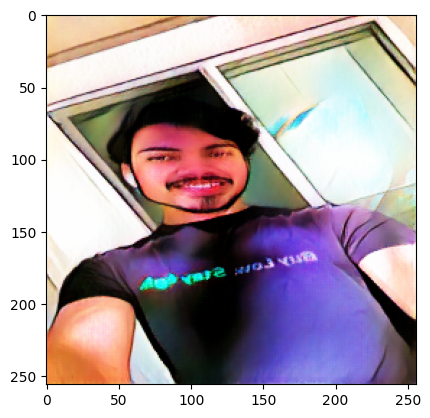

In [46]:
test_image = Image.open('deva/IMG_0488.JPG')
test_image = T.Compose([T.Resize([256,256]), T.ToTensor()])(test_image).unsqueeze(0)
result_images_best_checkpoint = G_inference(test_image)
result_images_checkpoint_after_210_epochs = G(test_image.to(device))
print(result_images_best_checkpoint[0])
plt.imshow(np.transpose(result_images_best_checkpoint[0].detach().numpy(), (1, 2, 0)))

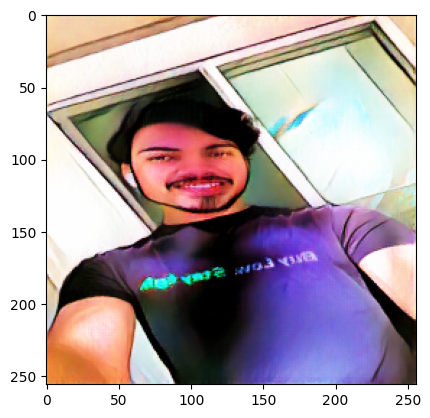

In [47]:
plt.imshow(np.transpose(result_images_checkpoint_after_210_epochs[0].cpu().detach().numpy(), (1, 2, 0)))

In [48]:
import gradio as gr
import io
from skimage.transform import resize


# Define your functions for Full Stack and Cartoon GAN
def full_stack(input_text, include_cartoon):
    # Functionality for Full Stack
    output = "You entered: " + input_text + ". Full Stack tab is selected."
    if include_cartoon:
        output += " Cartoon option is selected."
    return None

def cartoon_gan(input_image):
    img = Image.open(input_image)
    # set up transformation to resize the image
    transform = T.Compose([
        T.Resize([256, 256]),
        T.ToTensor()
    ])
    img = transform(img).unsqueeze(0)

    result_image_checkpoint_after_210_epochs = G(img.to(device))
    cartoon = np.transpose(result_image_checkpoint_after_210_epochs[0].cpu().detach().numpy(), (1, 2, 0))

    return cartoon

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [49]:
# Create Gradio interfaces
full_stack_interface = gr.Interface(fn=full_stack, inputs=[gr.Textbox(label="Input Prompt"), gr.Checkbox(label="Cartoonize?", min_width=190)], outputs="image", title="Full Pipeline")
cartoon_gan_interface = gr.Interface(fn=cartoon_gan, inputs=gr.Image(type='filepath'), outputs="image", title="Cartoon GAN")

# Launch the interface
tabbed_interface = gr.TabbedInterface(interface_list=[full_stack_interface, cartoon_gan_interface], tab_names = ['Full Pipeline', 'Cartoon GAN'], title="Tabbed Interface", theme="compact")

# Launch the interface
tabbed_interface.launch(share=True)

/opt/conda/lib/python3.10/site-packages/gradio/blocks.py:699: UserWarning: Cannot load compact. Caught Exception: The space compact does not exist
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")
/opt/conda/lib/python3.10/site-packages/gradio/blocks.py:954: UserWarning: api_name predict already exists, using predict_1
  warnings.warn(


IMPORTANT: You are using gradio version 3.41.0, however version 4.29.0 is available, please upgrade.
--------
IMPORTANT: You are using gradio version 3.41.0, however version 4.29.0 is available, please upgrade.
--------
Running on local URL:  http://127.0.0.1:7860
IMPORTANT: You are using gradio version 3.41.0, however version 4.29.0 is available, please upgrade.
--------
Running on public URL: https://739326c77a564938e6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/PIL/Image.py", line 3222, in open
    fp.seek(0)
AttributeError: 'NoneType' object has no attribute 'seek'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/gradio/routes.py", line 488, in run_predict
    output = await app.get_blocks().process_api(
  File "/opt/conda/lib/python3.10/site-packages/gradio/blocks.py", line 1435, in process_api
    result = await self.call_function(
  File "/opt/conda/lib/python3.10/site-packages/gradio/blocks.py", line 1107, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/opt/conda/lib/python3.10/site-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/opt/conda/lib/python3.10/site-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await futur

In [47]:
exit()

Killing tunnel 127.0.0.1:7866 <> https://0854d1631af904aa1c.gradio.live
Killing tunnel 127.0.0.1:7865 <> https://153a38db356ef34de8.gradio.live
Killing tunnel 127.0.0.1:7864 <> https://2cbe4f065de9ab65f0.gradio.live
Killing tunnel 127.0.0.1:7863 <> https://019210185cfd76331d.gradio.live
Killing tunnel 127.0.0.1:7862 <> https://7dde2e4d3ce116f492.gradio.live
Killing tunnel 127.0.0.1:7861 <> https://c6e2fc4f352ad61d51.gradio.live
Killing tunnel 127.0.0.1:7860 <> https://830764ce7c4e45a3e5.gradio.live
